In [1]:
# Annie Polish
# Summer 2019

# README: How to prepare data for this script
# Open DatCon (from datfile.net)
# Set Parsing Options to "Engineered, then DatDefined"
# Set the Sample Rate to 100Hz
# Set the output location to ./CSV_files (relative to this script)
# GO!
# In this file, set BASENAME to the name of your file
# Run this script. The plot will be saved to ./plots

import matplotlib as mpl
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import pandas as pd
import pymap3d as pm
from math import *
from datetime import datetime
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopy.distance

plt.rcParams.update({'font.size': 16})

# global forward declaration
rtk_p = pd.DataFrame(columns=["Lat", "Lon", "hmsl"])

In [2]:
########################
# CONSTANT DEFINITIONS #
########################
BASENAME = "FLY148" # filename to run on
BORDER = 0.00007 # sets the border around the dataset, in degrees of lat/long
PLOT_BG = cimgt.GoogleTiles(desired_tile_form='RGB', style='satellite')
COL_LIST = ["rtkdata:Lat_P", "rtkdata:Lon_P", "rtkdata:Hmsl_P", "GPS:dateTimeStamp", "offsetTime"]

Change "BASENAME" to set which file you run on

All CSVs should be in ./CSV_files

Plots land in ./plots

In [3]:
# accepts a DataFrame with "Lat", "Lon", "hmsl"
# fills in the isMoving column with bools
# isMoving is a guess at whether the drone is currently moving
def fill_moving(df: pd.DataFrame, xy_thresh= 0.00000003, h_thresh=0.005, win = 50):
    latSer = pd.Series(df["Lat"].values, index=df.index)
    lonSer = pd.Series(df["Lon"].values, index=df.index)
    hmslSer= pd.Series(df["hmsl"].values,index=df.index)
    df = df.assign(std_lat = latSer.rolling(50, center=True).std())
    df = df.assign(std_lon = lonSer.rolling(50, center=True).std())
    df = df.assign(std_hmsl = hmslSer.rolling(50, center=True).std())
    df = df.assign(isMoving = np.logical_or(np.greater(df["std_lat"].values, xy_thresh), 
        np.greater(df["std_lon"].values, xy_thresh),
        np.greater(df["std_hmsl"].values, h_thresh)))
    return df

In [4]:
# fill in moving averages
def fill_avMov(df: pd.DataFrame, win = 20):
    latSer = pd.Series(df["Lat"].values, index=df.index)
    lonSer = pd.Series(df["Lon"].values, index=df.index)
    hmslSer= pd.Series(df["hmsl"].values,index=df.index)
    df = df.assign(avMovLat = latSer.rolling(win, center=True).mean())
    df = df.assign(avMovLon = lonSer.rolling(win, center=True).mean())
    df = df.assign(avMovHmsl = hmslSer.rolling(win, center=True).mean())
    return df

In [5]:
# returns the statistics of the coordinates in a given time interval
def stationaryStats(df, startTime, endTime, avg=False):
    print('hello stationary stats')
    # slice off part of the dataframe
    df_slice = df[df["sec_elapsed"] > startTime]
    df_slice = df_slice[df_slice["sec_elapsed"] < endTime]
    if (avg):
        lat_arr = df_slice["avMovLat"].values
        lon_arr = df_slice["avMovLon"].values
        hmsl_arr= df_slice["avMovHmsl"].values
    else:
        lat_arr  = df_slice["Lat"].values
        lon_arr  = df_slice["Lon"].values
        hmsl_arr = df_slice["hmsl"].values
    # find max and min of each coordinate, and the distance that represents
    max_lat  = np.max(lat_arr)
    min_lat  = np.min(lat_arr)
    max_lon  = np.max(lon_arr)
    min_lon  = np.min(lon_arr)
    lat_dist = geopy.distance.distance((min_lat, lon_arr[0]), (max_lat, lon_arr[0])).m
    lon_dist = geopy.distance.distance((lat_arr[0], min_lon), (lat_arr[0], max_lon)).m
    print("Latitude spread: "+str(lat_dist))
    print("Longitude spread: "+str(lon_dist))
    print("Diagonal distance: "+str(sqrt(lat_dist**2 + lon_dist**2)))
    print("Double check: "+str(geopy.distance.distance((min_lat, min_lon),(max_lat, max_lon)).m))
    # find the standard deviation of each coordinate
    lat_dev  = np.std(lat_arr)
    lon_dev  = np.std(lon_arr)
    hmsl_dev = np.std(hmsl_arr)
    # convert stddev in degrees to stddev in meters
    startCoords = (lat_arr[0], lon_arr[0])
    latCoords = (lat_arr[0]+lat_dev, lon_arr[0])
    lonCoords = (lat_arr[0], lon_arr[0]+lon_dev)
    endCoords = (lat_arr[0]+lat_dev, lon_arr[0]+lon_dev)
    lat_dist = geopy.distance.distance(startCoords, latCoords).m
    lon_dist = geopy.distance.distance(startCoords, lonCoords).m
    xy_dist = geopy.distance.distance(startCoords, endCoords).m
    # print and return
    print("Latitude standard deviation: "+str(lat_dist)+" meters")
    print("Longitude standard deviation: "+str(lon_dist)+" meters")
    print("Height standard deviation: "+str(hmsl_dev)+" meters")
    print("Diagonal lat-lon stddev: "+str(xy_dist)+" meters")
    return (lat_dist, lon_dist, hmsl_dev, xy_dist)

In [6]:
# measure the distance between two second markers
def distBetweenTimes(df, startTime, endTime):
    df_slice = df[df["sec_elapsed"] > startTime]
    df_slice = df_slice[df_slice["sec_elapsed"] < endTime]
    start_lat = df_slice.iloc[0]["Lat"]
    start_lon = df_slice.iloc[0]["Lon"]
    end_lat = df_slice.iloc[-1]["Lat"]
    end_lon = df_slice.iloc[-1]["Lon"]
    dist = geopy.distance.distance((start_lat, start_lon), (end_lat, end_lon)).m
    print(start_lat)
    print(start_lon)
    print(end_lat)
    print(end_lon)
    print("distance: "+str(dist))
    return(dist)

In [7]:
# slice up the dataframe
def chopTime(df, startTime, endTime):
    df_slice = df[df["sec_elapsed"] > startTime]
    df_slice = df_slice[df_slice["sec_elapsed"] < endTime]
    return(df_slice)

In [8]:
# adds the column time_int
# expects to find "sec_elapsed" and "sec_abs"

def interpolateTime(df):

    # get a clock tick near sec_elapsed = 0
    in_flight  = df[df["sec_elapsed"] > 0]
    first_time = in_flight["datetimestamp"].values[0]
    tick_row = 0
    # find the first in-flight clock tick
    while in_flight["datetimestamp"].values[tick_row] == first_time:
        tick_row += 1
        
    # we are declaring this row to be t=0
    init_time = np.datetime64(df["datetimestamp"].values[tick_row])
    print(init_time)
    # shift sec_elapsed to fit this
    sec_offset = -1.*in_flight['sec_elapsed'].values[tick_row]
    print(sec_offset)
    
    secs = np.add(df["sec_elapsed"].values, sec_offset)
    deltas = []
    #print(secs)
    i=0
    for row in secs:
        #print(row)
        sec = floor(row)
        milli = int((row - sec)*1000)
        sec_delta = np.timedelta64(sec, 's')
        mil_delta = np.timedelta64(milli, 'ms')
        delta = sec_delta + mil_delta
        deltas.append(delta)
        i+=1
    #print(deltas)
    
    moved_times = []
    for i in range(len(deltas)):
        moved_times.append(init_time + deltas[i])
    
    df = df.assign(timestamp = moved_times)
    print(moved_times)
    return(df)

In [9]:
# uses pymap3d for coordinate transformation
def makeENU(df, startTime=0, endTime=len(rtk_p["Lat"].values), lat_origin=0, lon_origin=0, height_origin=0):
    # find the origin of our transformed coordinate system
    # z first:
    if (height_origin == 0):
        height_origin = np.mean(df[df["sec_elapsed"] < 0]["hmsl"].values)
        if (height_origin == 0 or np.isnan(height_origin)):
            height_origin = np.min(df['hmsl'].values)
        print(height_origin)
    
    # lat+long:
    df_slice = df[df["sec_elapsed"] > startTime]
    df_slice = df_slice[df_slice["sec_elapsed"] < endTime]
    if (lat_origin == 0): lat_origin = np.mean(df_slice["Lat"].values)
    if (lon_origin == 0): lon_origin = np.mean(df_slice["Lon"].values)
    print(lat_origin)
    print(lon_origin)
    
    east, north, up = pm.geodetic2enu(df["Lat"].values, df["Lon"].values, df["hmsl"].values,
                                      lat_origin, lon_origin, height_origin)
    
    az, el, ran = pm.geodetic2aer(df_slice["Lat"].values, df_slice["Lon"].values, df_slice["hmsl"].values,
                                      lat_origin, lon_origin, height_origin)
    
    #%matplotlib notebook
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.set_aspect("equal")
    ax.plot(east, north, up)
    #ax.plot(rot_coords[:,0], rot_coords[:,1], rot_coords[:,2])
    ax.scatter(0,0,0, color='red')
    plt.xlabel("East")
    plt.ylabel("North")
    plt.savefig("./plots/ENU_"+BASENAME+".png")
    plt.show()
    
    #%matplotlib notebook
    fig = plt.figure(figsize=(10,10))
    #ax = fig.add_subplot(1,1,1,projection='3d')
    ax.set_aspect("equal")
    plt.plot(az, el)
    #ax.plot(rot_coords[:,0], rot_coords[:,1], rot_coords[:,2])
    #ax.scatter(0,0,0, color='red')
    plt.xlabel("Azimuth")
    plt.ylabel("Elevation")
    plt.title("Az/El as seen from below flight pattern")
    plt.tight_layout()
    plt.grid()
    plt.savefig("./plots/az_el_"+BASENAME+".png")
    plt.show()
    
    df = df.assign(east = east)
    df = df.assign(north = north)
    df = df.assign(up = up)
    
    return(df)

In [10]:
def sanityCheck(df):
    is_sane = True
    sanity_col = []
    
    times = df["timestamp"].values
    secs = df["sec_elapsed"].values
    
    last_time = times[0]
    last_sec = secs[0]
    i = 0
    
    for sec in secs:
        sanity_col.append(True)
        if sec < last_sec:
            is_sane = False
            sanity_col[i] = False
            print("sec_elapsed ran backwards at "+str(i)+": "+str(sec))
        last_sec = sec
        i += 1
    
    i = 0
    for time in times:
        if time < last_time:
            is_sane = False
            sanity_col[i] = False
            print("------------------------")
            print("before: "+str(times[i-1]))
            print("timestamp ran backwards at "+str(i)+": "+str(time))
            print("after: "+str(times[i+1]))
        last_time = time
        i += 1
        
    if (is_sane): print("sanity check passed")
        
    df = df.assign(sanity = sanity_col)
    return(df, is_sane)

In [11]:
FLY = pd.read_csv("./CSV_files/"+BASENAME+".csv", sep=",", header=0, usecols=COL_LIST)#, nrows=15000)

In [12]:
# retrieve the date
print(FLY["GPS:dateTimeStamp"].values[100])
date = FLY["GPS:dateTimeStamp"].values[100]
stamp = date
date = date[:10]

# rename columns, do some initial processing
rtk_p = pd.DataFrame(columns=["Lat", "Lon", "hmsl"])
rtk_p["Lat"] = FLY["rtkdata:Lat_P"]
rtk_p["Lon"] = FLY["rtkdata:Lon_P"]
rtk_p["hmsl"] = FLY["rtkdata:Hmsl_P"]
rtk_p["sec_elapsed"] = FLY["offsetTime"]
rtk_p["datetimestamp"] = FLY["GPS:dateTimeStamp"]
rtk_p = rtk_p.iloc[20:]
rtk_p = rtk_p.iloc[:-20]
rtk_p = rtk_p.where(rtk_p != 0.)
#print(rtk_p)
rtk_p.dropna(inplace=True)


2019-07-11T20:08:58Z


In [13]:
# cut out irrelevant data
#rtk_p = chopTime(rtk_p, 0, 750)

In [14]:
rtk_p = interpolateTime(rtk_p)


2019-07-11T20:08:58
-0.63
[numpy.datetime64('2019-07-11T20:08:57.741'), numpy.datetime64('2019-07-11T20:08:57.751'), numpy.datetime64('2019-07-11T20:08:57.761'), numpy.datetime64('2019-07-11T20:08:57.772'), numpy.datetime64('2019-07-11T20:08:57.782'), numpy.datetime64('2019-07-11T20:08:57.792'), numpy.datetime64('2019-07-11T20:08:57.802'), numpy.datetime64('2019-07-11T20:08:57.814'), numpy.datetime64('2019-07-11T20:08:57.824'), numpy.datetime64('2019-07-11T20:08:57.835'), numpy.datetime64('2019-07-11T20:08:57.846'), numpy.datetime64('2019-07-11T20:08:57.856'), numpy.datetime64('2019-07-11T20:08:57.866'), numpy.datetime64('2019-07-11T20:08:57.876'), numpy.datetime64('2019-07-11T20:08:57.886'), numpy.datetime64('2019-07-11T20:08:57.896'), numpy.datetime64('2019-07-11T20:08:57.907'), numpy.datetime64('2019-07-11T20:08:57.917'), numpy.datetime64('2019-07-11T20:08:57.927'), numpy.datetime64('2019-07-11T20:08:57.938'), numpy.datetime64('2019-07-11T20:08:57.948'), numpy.datetime64('2019-07-11

/home/annie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  from ipykernel import kernelapp as app


/home/annie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/annie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/annie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/home/annie/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/annie/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<class 'pandas.core.frame.DataFrame'>
42.628227
41.32059
-72.92244


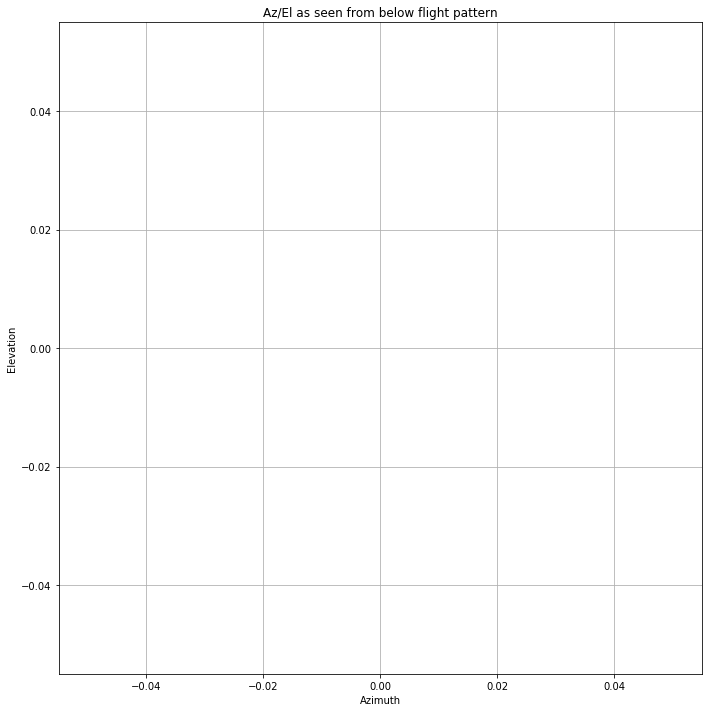

<class 'pandas.core.frame.DataFrame'>


In [15]:
rtk_p = fill_moving(rtk_p)
rtk_p = fill_avMov(rtk_p)
#print(rtk_p)
rtk_p.dropna(inplace=True)
print(type(rtk_p))
rtk_p = makeENU(rtk_p, lat_origin=41.32059, lon_origin=-72.92244)
print(type(rtk_p))

In [16]:
rtk_p, sanity = sanityCheck(rtk_p)

sec_elapsed ran backwards at 5915: 0.24600000000000002
------------------------
before: 2019-07-11T20:09:59.402000000
timestamp ran backwards at 5915: 2019-07-11T20:08:57.616000000
after: 2019-07-11T20:08:57.627000000


In [17]:
# export data for will
np.savez(BASENAME+"_Drone_Coordinates.npz",timestamp=rtk_p['timestamp'].values,Lat=rtk_p['Lat'].values,Lon=rtk_p['Lon'].values,hmsl=rtk_p['hmsl'].values)

In [18]:
# Plot flight path on top of sattillite imagery

# begin the plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=PLOT_BG.crs) # add a subplot in the coordinate system of the tiles
ax.set_extent([min(rtk_p["Lon"].values)-BORDER, max(rtk_p["Lon"].values)+BORDER, 
    min(rtk_p["Lat"].values)-BORDER, max(rtk_p["Lat"].values)+BORDER], crs=ccrs.Geodetic()) # set plot size
ax.add_image(PLOT_BG, 20, interpolation='spline36') # go get some map tiles
# plot the RTK gps data
plt.plot(rtk_p["avMovLon"].values, rtk_p["avMovLat"].values, 'c', linewidth=2, transform=ccrs.Geodetic(), label="RTK")
# label stuff and save
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("RTK data - "+BASENAME+" "+str(date))
plt.grid()
fig.canvas.draw()
plt.tight_layout()
plt.savefig("./plots/"+BASENAME+".png")
print("saved plot")
plt.show()

ValueError: A non-empty list of tiles should be provided to merge.

ValueError: A non-empty list of tiles should be provided to merge.

<Figure size 720x720 with 1 Axes>

In [ ]:
# Plot flight path on top of sattillite imagery

# begin the plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=PLOT_BG.crs) # add a subplot in the coordinate system of the tiles
ax.set_extent([min(rtk_p["Lon"].values)-BORDER, max(rtk_p["Lon"].values)+BORDER, 
    min(rtk_p["Lat"].values)-BORDER, max(rtk_p["Lat"].values)+BORDER], crs=ccrs.Geodetic()) # set plot size
ax.add_image(PLOT_BG, 20, interpolation='spline36') # go get some map tiles
rtk_mov = rtk_p[rtk_p["isMoving"] == True]
print(len(rtk_mov["Lat"].values))
rtk_stop = rtk_p[rtk_p["isMoving"] == False]
print(len(rtk_stop["Lat"].values))
# plot the RTK gps data
plt.plot(rtk_p["avMovLon"].values, rtk_p["avMovLat"].values, 'c', linewidth=2, transform=ccrs.Geodetic(), label="RTK")
plt.scatter(rtk_stop["Lon"].values, rtk_stop["Lat"].values, color='m', transform=ccrs.Geodetic())
# label stuff and save
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("RTK data - "+BASENAME+" "+str(date))
plt.grid()
fig.canvas.draw()
plt.tight_layout()
plt.savefig("./plots/"+BASENAME+".png")
print("saved plot")
plt.show()

In [ ]:
# Plot longitude vs time

print(type(rtk_p['timestamp'].values[0]))

rtk_insane = rtk_p[rtk_p["sanity"] == False]

fig = plt.figure(figsize=(9,9))
plt.title("Longitude vs Seconds Elapsed")
plt.ylim(min(rtk_p["Lon"].values), max(rtk_p["Lon"].values))
plt.plot(rtk_p["timestamp"].values, rtk_p["Lon"].values)
plt.scatter(rtk_insane["timestamp"].values, rtk_insane["Lon"].values, color="m")
plt.grid()
ax = plt.gca()
ax.yaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_minor_formatter(LONGITUDE_FORMATTER)
#plt.xlim(0,max(rtk_p["timestamp"].values))
plt.tight_layout()
plt.savefig("./plots/"+BASENAME+"_lon.png")
plt.show()

In [ ]:
fig = plt.figure(figsize=(9,9))
plt.title("Latitude vs Seconds Elapsed")
plt.ylim(min(rtk_p["Lat"].values), max(rtk_p["Lat"].values))
plt.plot(rtk_p["sec_elapsed"].values, rtk_p["Lat"].values)
plt.grid()
ax = plt.gca()
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
ax.yaxis.set_minor_formatter(LATITUDE_FORMATTER)
plt.xlim(0,max(rtk_p["sec_elapsed"].values))
plt.savefig("./plots/"+BASENAME+"_lat.png")
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.title("Height vs Elapsed Time (seconds)")
plt.ylim(min(rtk_p["hmsl"].values), max(rtk_p["hmsl"].values))
plt.plot(rtk_p["sec_elapsed"].values, rtk_p["hmsl"].values)
plt.grid()
plt.savefig("./plots/"+BASENAME+"_hmsl.png")
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(rtk_p['Lon'].values, rtk_p['Lat'].values, rtk_p['hmsl'].values)
plt.savefig("./plots/3d"+BASENAME+".png")
plt.show()

In [ ]:
if(BASENAME == "FLY088"):
    stationaryStats(rtk_p,50,140)
    stationaryStats(rtk_p,200,280)
    stationaryStats(rtk_p,340,430)
    stationaryStats(rtk_p,490,600)
    stationaryStats(rtk_p,650,750)
    stationaryStats(rtk_p,800,900)
    stationaryStats(rtk_p,950,1050)
    stationaryStats(rtk_p,1090,1180)

if(BASENAME == "FLY097"):
    stationaryStats(rtk_p,250,330)
    stationaryStats(rtk_p,400,470)
    stationaryStats(rtk_p,500,600)
    stationaryStats(rtk_p,650,720)
    stationaryStats(rtk_p,780,860)
    stationaryStats(rtk_p,900,980)
    stationaryStats(rtk_p,1030,1100)
    stationaryStats(rtk_p,1150,1300)
    
if(BASENAME == "FLY120"):
    stationaryStats(rtk_p,145,175)
    stationaryStats(rtk_p,150,170)
    stationaryStats(rtk_p,185,215)
    stationaryStats(rtk_p,225,255)
    stationaryStats(rtk_p,275,540)
    
if(BASENAME == "FLY117"):
    stationaryStats(rtk_p,100,200, avg=True)
    stationaryStats(rtk_p,220,250, avg=True)
    stationaryStats(rtk_p,270,290, avg=True)
    stationaryStats(rtk_p,310,325, avg=True)
    
if(BASENAME == "FLY126"):
    stationaryStats(rtk_p,100,200)
    stationaryStats(rtk_p,275,350)
    
#FLY88:
#(50,140), (200,280), (340,430), (490,600), (650,750), (800,900), (950,1050), (1090,1180)

In [ ]:
## FLY88, FLY97 ##
#distBetweenTimes(rtk_p, 270, 410)

## FLY117 ##
distBetweenTimes(rtk_p, 150, 240)
distBetweenTimes(rtk_p, 240, 280)
distBetweenTimes(rtk_p, 280, 315)
distBetweenTimes(rtk_p, 315, 350)
## FLY120 ##
#distBetweenTimes(rtk_p, 100, 160)
#distBetweenTimes(rtk_p, 160, 200)
#distBetweenTimes(rtk_p, 200, 240)
#distBetweenTimes(rtk_p, 240, 300)